<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 6 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 20 March 2020, with material from Thomas Wiecki</div>

# Metropolis lab 1

We worked with estimating the **mean** of a model in our first notebook, so let's estimate **standard deviation** in this notebook. You will write your own [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm). You will also improve on a little bit of sloppy work by professor: He did not take the **log** of probabilities in his lab, resulting in underflows in his simulations.

In [23]:
import numpy as np

In [24]:
import scipy
import scipy.stats

## Step 1: Data generation

We generate 30,000 samples from a normal distribution with $\mu$ = 10, and $\sigma$= 3, but let's say we can only observe 1000 of them. 

Lab goal: We'll use Bayesian estimation to build a model from the 1000 observations, then we'll use the model to reconstruct (a simulation of) the 30,000 samples.

Let's start by plotting the histogram of these observed 1000 datapoints. Our generating model is a normal distribution.

In [25]:
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline

9.941710332665417

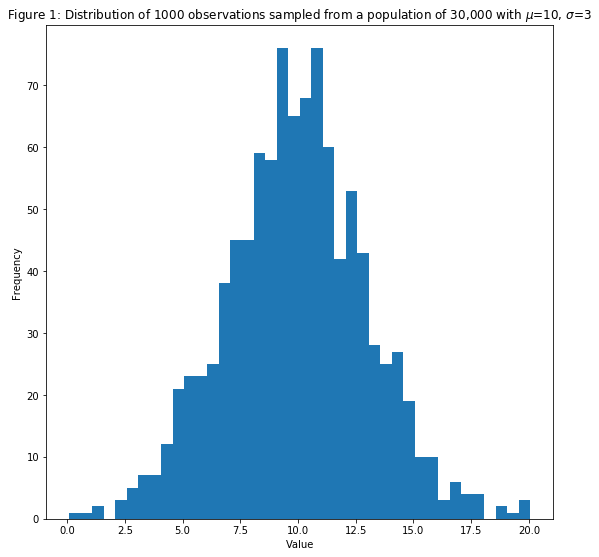

In [27]:
model=lambda mu, sig, t: np.random.normal(mu, sig, t)

#Form a population of 30,000 individuals, with average=10 and sigma=3
population = model(10, 3, 30000)

#Assume we are only able to observe 1,000 of these individuals, sampled randomly amongst the 30000.
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(2,2,2)
ax.hist( observation,bins=40 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with $\mu$=10, $\sigma$=3")
mu_obs=observation.mean()
mu_obs

## Step 2: Which parameter to model

Our $\theta$ is made up of two values: $[\mu,\sigma]$. Let's assume  $\mu$ is a constant, $\mu = \mu_{obs}$. What you computed above.

We would like to find a distribution for $\sigma_{obs}$ using the 1000 observed samples. 

Those with a math background will say... Professor! ***There is a formula for computing the standard deviation $\sigma$ of gaussian-looking data***! Actually, ***y'all need to know how to compute standard deviation from $n$ observations $d_i$ with mean $\mu$***):

$$\sigma=\sqrt{\frac{1}{n}\sum_i^n(d_i-\mu)^2}$$

Note however, we are not trying to find *a* value for $\sigma$, but rather, we are trying to ***compute a distribution of the possible values of $\sigma$***.

## Step 3: Define the pdf for the prior for model parameter(s), and the pdf for the likelihood of the data
From the figure above, we can see that the data is **normally distributed**. The mean can be easily computed by taking the average of the values of the 1000 samples. By doing that, we get for example $\mu_{obs}=9.8$.

Now, let's start picking the pdf's for our model parameters. For the standard deviation pdf, let's pick a simple one: the normal distribution!

\begin{equation} \sigma_{new} \sim N(\mu=\sigma_{current},\; \sigma'=1) \end{equation}

Note that $\sigma'$ is *unrelated* to $\sigma_{new}$ and $\sigma_{current}$. It simply specifies the standard deviation of the parameter's pdf. It can be *any* value desired. It only affects the convergence time of the algorithm.

We don't have any preferences values that $\sigma_{new}$ and $\sigma_{current}$ can take, but they should be positive! Why? Intuitively, the standard deviation measures **dispersion**. Dispersion is a distance, and distances cannot be negative.

Mathematically, $\sigma=\sqrt{\dfrac{1}{n}\sum_i^n(d_i-\mu)^2}$, and the square root of a number cannot be negative. We should strictly enforce this in the prior. Enforcing constraints is important in the model because otherwise we may oscillate between realistic and unrealistic solutions.

Since likelihood $f$ should be proportional to the posterior, we choose $f$ to be the following pdf, for each data point $d_i$ in the data D:

\begin{equation} f(d_i\;|\; \mu,\sigma^2) = \dfrac{1}{\sqrt{2\pi\sigma^2}}e^{-\dfrac{(d_i-\mu)^2}{2\sigma^2}} \end{equation}

#### Question 1) Compute the standard deviation of the 30,000 samples, and then the standard deviation of the 1,000 observations in the cell below. Same or different?

Note that the standard deviation of a non-gaussian distribution is ***nonsense***! Thankfully here, we have a distribution that ***is*** gaussian-distributed. 

In [28]:
def calculation(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

In [29]:
population_SD = np.std(population)
population_SD

2.9967602681053944

In [30]:
observation_SD = np.std(observation)
observation_SD

3.038684035700531

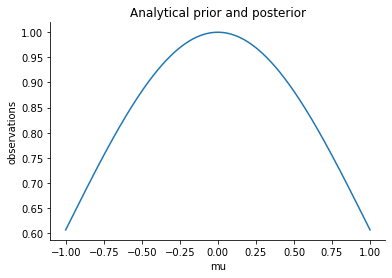

In [31]:
import seaborn as sns
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
like =gaussian(x,0.,1.)
ax.plot(x, like)
ax.set(xlabel='mu' , ylabel='observations' , title='Analytical prior and posterior');
sns.despine()

## Step 4: Define when we accept or reject $\sigma_{new}$: 
From our lab, we know to accept $\sigma_{new}$ from $\sigma_{current}$ if:

$\dfrac{\text{Likelihood}(D \;|\; \mu_{obs},\sigma_{new})\; * \; \text{prior}(\mu_{obs},\sigma_{new})}{\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{current})\;*\;\text{prior}(\mu_{obs},\sigma_{current})} \;\;>\;\; 1     \quad \quad \quad \quad \quad      (1)$

Otherwise, if this ratio is smaller or equal to 1, then we compare it to a uniformly generated random number in the closed set [0,1]. If the ratio is larger than the random number, we accept $\sigma_{new}$, otherwise we reject it.

*Note: Since we will be computing this ratio to decide which parameters should be accepted, make sure that the adopted likelihood is proportional to the posterior itself, $P(\sigma\;|\; D,\mu)$, which in our case is true.*


## Step 5: Acceptance condition derivation:

Just like the likelihood of flipping a coin 10 times and obsering 10 tails is $(0.5)^{10}$, the total likelihood for a set of observations $D$ when we have the probability of each observation $f(d_i\;|\;\mu,\sigma)$ is: $\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{new}) = \prod_i^n f(d_i\;|\;\mu_{obs},\sigma_{new})  \quad \quad \quad \quad \quad      (2)$

In our case, we will take the **log** of both the prior and the likelihood function. Why the log? Simply because it helps with **numerical stability**. Multiplying thousands of small values (probabilities, likelihoods, etc..) can cause an **underflow** in system memory, and the **log** is a perfect solution because it transforms multiplications to **additions** and small positive numbers into not-so-small negative numbers.

Therefore our acceptance condition from equation $(1)$ which is:
Accept $\sigma_{new}$ if:

$$\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{new}) * \text{prior}(\mu_{obs},\sigma_{new})) > \\ \text{Likelihood}(D\;|\:\mu_{obs},\sigma_{current}) *  \text{prior}(\mu_{obs},\sigma_{current}))$$

After taking the **log** of equation (1), which we can since **log** is a [monotonic](https://en.wikipedia.org/wiki/Monotonic_function) function, equation (1) becomes:

$$Log[\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{new}) * \text{prior}(\mu_{obs},\sigma_{new}))] > \\ Log[\text{Likelihood}(D\;|\:\mu_{obs},\sigma_{current}) *  \text{prior}(\mu_{obs},\sigma_{current}))]$$

But since $Log(a * b) = Log(a) + Log(b)$, our condition becomes:

$$Log(\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{new})) + Log(\text{prior}(\mu_{obs},\sigma_{new})) - (Log(\text{Likelihood}(D\;|\:\mu_{obs},\sigma_{current})) + Log(prior(\mu_{obs},\sigma_{current})))\;>\;0$$

By plugging in $\text{Likelihood}(D\;|\;\mu_{obs},\sigma_{new}) = \prod_i^n f(d_i\;|\;\mu_{obs},\sigma_{new}) $, our condition becomes:

 $$\sum_i^nLog(f(d_i\;|\;\mu_{obs},\sigma_{new})) \;\; + Log(\text{prior}(\mu_{obs},\sigma_{new})) - \sum_i^nLog(f(d_i\;|\;\mu_{obs},\sigma_{current})) \;\; -Log(\text{prior}(\mu_{obs},\sigma_{current}))>0$$
 
 $\quad$
 
 
By plugging in \begin{equation} f(d_i\;|\; \mu,\sigma^2) = \dfrac{1}{\sqrt{2\pi\sigma^2}}e^{-\dfrac{(d_i-\mu)^2}{2\sigma^2}} \end{equation}

Our condition becomes: 
  
$$\sum_i^n -Log(\sigma_{new}\sqrt{2\pi})-\dfrac{(d_i-\mu_{obs})^2}{2\sigma_{new}^2} \;\;+\;\; Log(prior(\mu_{obs},\sigma_{new})) \quad > \\
\quad \sum_i^n -Log(\sigma_{current}\sqrt{2\pi})-\dfrac{(d_i-\mu_{obs})^2}{2\sigma_{current}^2} \;\;+\;\; Log(prior(\mu_{obs},\sigma_{current})) \quad \quad  (3)$$

Note that in our calculus above, we have liberaly used $log(a * b) = log(a) + log(b)$, $log(a^2) = 2 log(a)$, and $log(\frac{1}{a}) = -log(a)$.

So (3) will be our acceptance condition. If true, we will always accept $\sigma_{new}$ as our next value in the chain. If false, ***we will only accept it according to a probability equal to the ratio of the nominators*** (like in the lab notebook).

So let's write some code. Your homework is to replace ellipses (...) with code, to build your own Metropolis algorithm.

In [35]:
# The transition model defines how to move from sigma_current to sigma_new
# Our model has two parameters x: x[0] = mu, x[1] = sigma
# The first one is fixed, the second one we will model with a normal distribution with mu=x[1] and sigma=0.5
# Purpose of the trailing [0] is to unpackage a numpy array of a single number into the number itself. Simpler that way 
transition_model = lambda x: [x[0], np.random.normal(x[1], 0.5, (1,))[0]]


def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1)=0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined. Makes the 
    # new sigma infinitely unlikely.
    if(x[1] <= 0):
        return 0
    return 1


# Computes the likelihood of the data given a sigma (new or current) according to equation (3)
def manual_log_likelihood(x, data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

Example:

In [36]:
mu, sig = transition_model([mu_obs,0.1])
mu, sig

(9.941710332665417, 0.64082301703963)

#### Question 2) Please write your own Metropolis algorithm below

Note the inputs to your Metropolis algorithm:

`likelihood_computation(x,data)` is the **likelihood** that parameters x generated the data. That will be the function `manual_log_likelihood` written above.

`transition_model(x)`: is a function that draws a sample from a symmetric distribution and returns it.

`param_init` is the starting sample. So you start your Metropolis program with `x = param_init`

`iterations` is the number of accepted to generated

`data` are the observations we wish to model

`acceptance_rule(x, x_new)` is a predicate that decides whether to accept or reject the new sample.

So, start with x equal to `param_init`, and with two lists, one are the accepted values `accepted = []`, the other the rejected values `rejected = []`.

Then for index i ranging in `range(iterations)`, set `x_new` equal to `transition_model(x)`, and `x_likely` to `likelihood_computation(x, data)`. Then evaluate a new candidate `x_new_likely` in the same way.

Then plug in equation (3) as input to your `acceptance_rule`. Equation (3) can simply be written as comparing `(x_likely + np.log(prior(x))` to `(x_new_likely + np.log(prior(x_new))`. If the new value `x_new` is accepted, replace `x` with `x_new` in order to start the next iteration, and add `x_new` to the accepted list. If the new value `x_new` is rejected, then just add it to the rejected list.

At the end of `iterations`, return the accepted list and the rejected list as numpy arrays: `return np.array(accepted), np.array(rejected)`.

Simple, right?

In [37]:
# Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new > x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new - x)))

# Your Metropolis algorithm!
def metropolis_hastings(likelihood_computation, prior, transition_model, param_init, iterations, data, acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []
    for i in range (iterations):
        x_new = transition_model(x)
        x_lik = likelihood_computation(x,data)
        x_new_lik = likelihood_computation(x_new, data)
        if (acceptance(x_lik + np.log(prior(x)) , x_new_lik + np.log(prior(x_new)))):
            x= x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)      
                
    return np.array(accepted), np.array(rejected)

## Step 6: Run the algorithm with initial parameters and collect accepted and rejected samples

#### Question 3) Run your Metropolis algorithm with the following parameters:

- manual_log_likelihood
- prior
- transition_model
- [mu_obs, 0.1]
- 50000
- observation
- acceptance

In [38]:
accepted, rejected = metropolis_hastings(manual_log_likelihood, prior, transition_model, [mu_obs,0.1], 50000, 
                                         observation, acceptance)

C:\Users\Utkarsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
C:\Users\Utkarsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


In [39]:
len(accepted)

8591

In [40]:
len(rejected)

41409

The algorithm accepted 8803 samples (which might be different on each new run).

The last 10 samples contain the following  values for $\sigma$:

In [41]:
accepted[-10:,1]

array([2.92033884, 2.95401371, 3.1144153 , 3.03643865, 3.10582256,
       3.10844247, 2.99553553, 3.04791851, 3.05616029, 3.05534668])

Note that we have an array of single-point arrays, due to how we wrote our model.

In [42]:
print(accepted.shape)

(8591, 2)


#### Question 4) Plot accepted and rejected values:

(8591, 2)

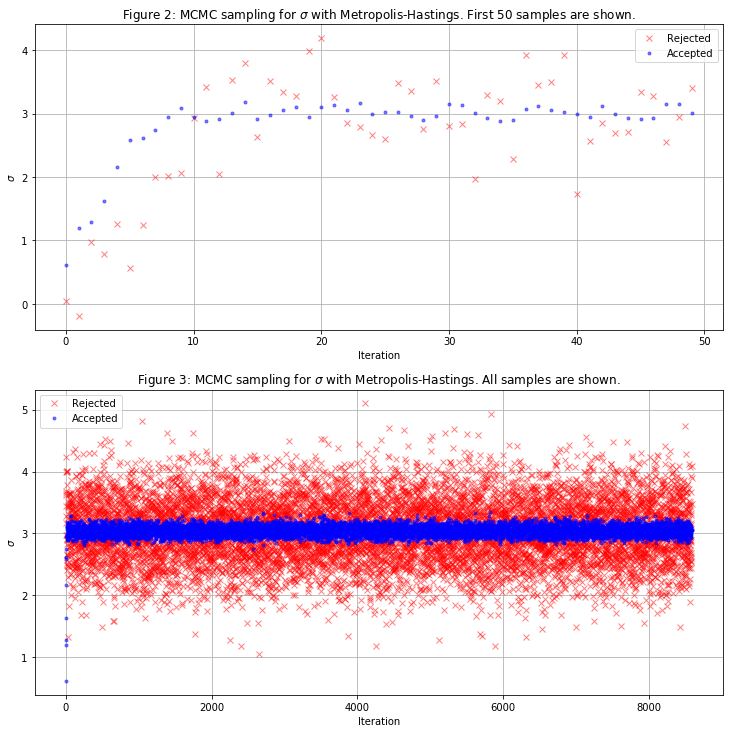

In [43]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(4,2,2)

ax.plot( rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(4,2,4)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()



fig.tight_layout()
accepted.shape

Notice how we sample our state space, accepting some samples and rejecting others, and converging to a mean of 3 (the peak of the distribution of our model's sigma parameter).

So, starting from an initial σ of 0.1, the algorithm converged pretty quickly to the expected value of 3.

### We consider the initial 25% of the values of $\sigma$ to be "burn-in", so we drop them.
### Let's visualize the trace of  $\sigma$ and the histogram of the trace.

C:\Users\Utkarsh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  from ipykernel import kernelapp as app


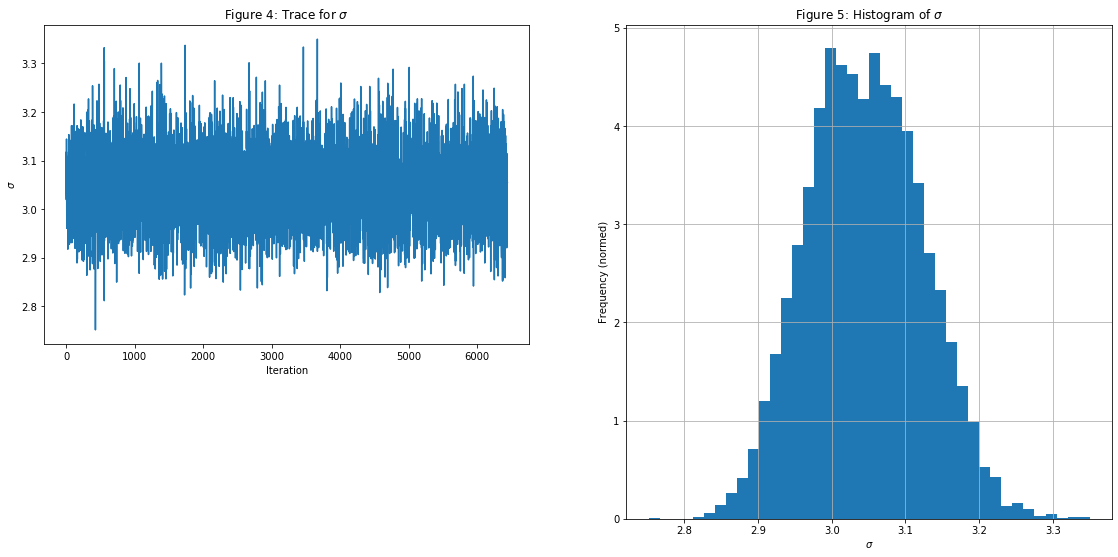

In [44]:
show=int(-0.75*accepted.shape[0])
hist_show=int(-0.75*accepted.shape[0])

fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(3,4,3)
ax.plot(accepted[show:,1])
ax.set_title("Figure 4: Trace for $\sigma$")
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(2,4,4)
ax.hist(accepted[hist_show:,1], bins=40,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\sigma$")
ax.set_title("Figure 5: Histogram of $\sigma$")
fig.tight_layout()


ax.grid("off")


### The most likely value for $\sigma$ is around 3.1. This is a bit more than the original value of 3.0. 

The difference is due to us observing only 3.33% of the original population (1,000 out of 30,000) 

## Predictions:
Now that we have a model, a much more powerful engine than just 1000 dataponts (!), let's make a prediction on what 30,000 individuals drawn from the same distribution look like.

#### Question 5)  First, average out the last 75% of accepted samples of σ, and then generate 30,000 random individuals from a normal distribution with μ=9.8 and your value of σ. Then compare against the original data of 30,000 individuals (fill in the `???`). Plot.

9.941710332665417 3.0455338312915092


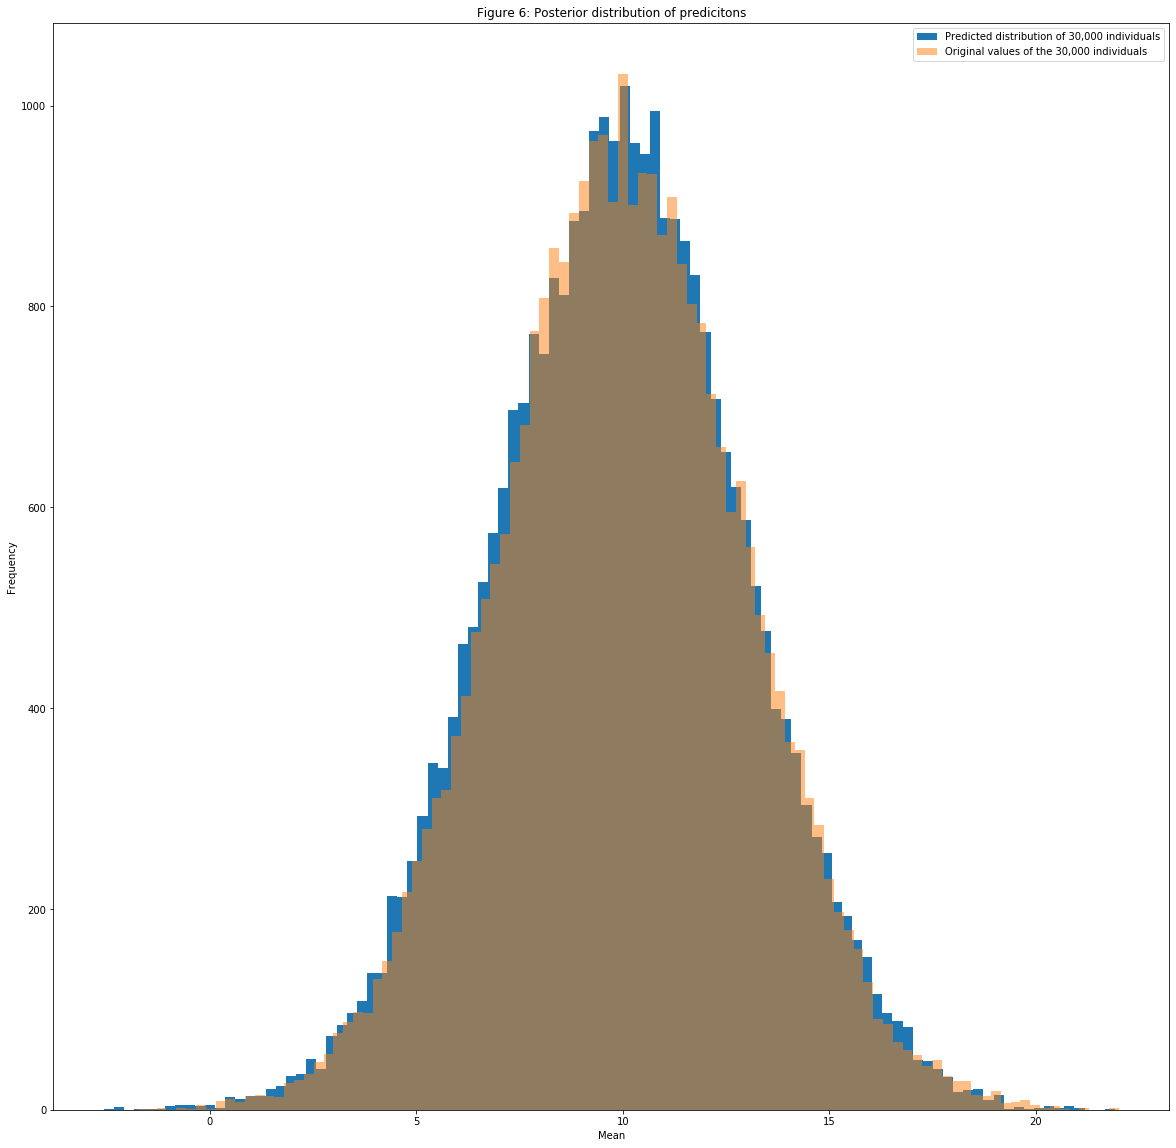

In [45]:
mu=accepted[show:,0].mean()
sigma=accepted[show:,1].mean()

print(mu, sigma)

model = lambda t,mu,sigma:np.random.normal(mu,sigma,t)

observation_gen=model(population.shape[0],mu,sigma)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=100 ,label="Predicted distribution of 30,000 individuals")
ax.hist( population,bins=100 ,alpha=0.5, label="Original values of the 30,000 individuals")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Figure 6: Posterior distribution of predicitons")
ax.legend()

Good fit! Our model, generated from a small 1,000 sample of 30,000 observations, suceeds in modelling all 30,000 observations!

## Conclusion

The great thing about probabilistic programming is that you only need to write down the model and then run it. The simplest MCMC algorithm, [Metropolis](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), is very simple. There is no need to compute evidence (denominator), or ensure constraining mathematical properties.

You are now a Metropolis wizard! You can predict the past from the future :-) After linear algebgra and graphs, you will be able to do the same thing in multiple dimensions, with a bit of help from Artificial Neural Networks!